In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0857.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0816.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0835.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0889.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0834.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0804.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0802.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0872.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0866.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0846.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0884.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0876.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0807.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0881.png
/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0821

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ===============================
# 1. Dataset Class
# ===============================
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, transform=None, scale_factor=4, crop_size=256):
        self.hr_dir = hr_dir
        self.hr_images = sorted(os.listdir(hr_dir))
        self.transform = transform
        self.scale_factor = scale_factor
        self.crop_size = crop_size  # Fixed size for HR images

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        # Load high-resolution image
        hr_image = Image.open(os.path.join(self.hr_dir, self.hr_images[idx])).convert("RGB")

        # Resize high-resolution image to a fixed crop size
        hr_image = hr_image.resize((self.crop_size, self.crop_size), Image.BICUBIC)

        # Generate low-resolution image by downscaling
        lr_image = hr_image.resize(
            (self.crop_size // self.scale_factor, self.crop_size // self.scale_factor),
            Image.BICUBIC
        )

        # Apply transformations
        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image


# ===============================
# 2. Define Models
# ===============================
# Generator: Transformer-based
class TransformerGenerator(nn.Module):
    def __init__(self, img_channels=3, embed_dim=64, num_blocks=8, num_heads=4):
        super(TransformerGenerator, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, embed_dim, kernel_size=3, stride=1, padding=1)

        # Transformer layers
        self.positional_encoding = nn.Parameter(torch.randn(1, embed_dim, 256 * 256))  # Fixed positional encoding
        self.blocks = nn.Sequential(
            *[nn.TransformerEncoderLayer(embed_dim, num_heads) for _ in range(num_blocks)]
        )

        self.conv2 = nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(embed_dim, embed_dim * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(embed_dim, img_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        batch_size, channels, height, width = x.shape

        # Initial convolution
        x = self.conv1(x)

        # Reshape to (batch_size, embed_dim, height * width)
        x = x.view(batch_size, -1, height * width)

        # Add positional encoding
        x = x + self.positional_encoding[:, :, : x.shape[-1]]

        # Pass through Transformer
        x = x.permute(2, 0, 1)  # Reshape to (sequence_length, batch_size, embed_dim)
        x = self.blocks(x)
        x = x.permute(1, 2, 0)  # Reshape back to (batch_size, embed_dim, sequence_length)

        # Reshape back to (batch_size, embed_dim, height, width)
        x = x.view(batch_size, -1, height, width)

        # Final upsampling
        x = self.upsample(x)
        return x


# Discriminator
# Updated Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Flatten(),
            nn.Linear(128 * (256 // 2) * (256 // 2), 1),
        )

    def forward(self, x):
        return self.model(x)  # No sigmoid

from torchvision.models import vgg19
import torch.nn.functional as F

# VGG-based Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self, layers=[0, 5, 10, 19, 28]):
        super(PerceptualLoss, self).__init__()
        vgg = vgg19(pretrained=True).features
        self.layers = layers
        self.model = nn.Sequential(*list(vgg)[:max(layers) + 1]).eval()
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, pred, target):
        loss = 0.0
        for i, layer in enumerate(self.model.children()):
            pred = layer(pred)
            target = layer(target)
            if i in self.layers:
                loss += F.mse_loss(pred, target)
        return loss
        
def gradient_penalty(discriminator, real_images, fake_images, device="cuda"):
    batch_size = real_images.size(0)
# Gradient Penalty for Discriminator Loss
    alpha = torch.rand(hr_images.size(0), 1, 1, 1).to(device)
    interpolates = alpha * hr_images + (1 - alpha) * fake_images
    interpolates.requires_grad_(True)
    disc_interpolates = discriminator(interpolates)

    grad_outputs = torch.ones_like(disc_interpolates).to(device)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty



# ===============================
# 3. Hyperparameters
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
batch_size = 16
lr = 1e-4
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ===============================
# 4. Prepare Data
# ===============================
train_hr_dir = "/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR"
valid_hr_dir = "/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR"

train_dataset = DIV2KDataset(train_hr_dir, transform=transform, crop_size=256)
valid_dataset = DIV2KDataset(valid_hr_dir, transform=transform, crop_size=256)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# ===============================
# 5. Initialize Models and Optimizers
# ===============================
generator = TransformerGenerator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

adversarial_loss = nn.BCELoss()
content_loss = nn.MSELoss()

# ===============================
# 6. Training Loop
# ===============================
perceptual_loss = PerceptualLoss().to(device)

lambda_adv = 1.0  # Weight for Wasserstein Loss
lambda_perc = 0.01  # Weight for Perceptual Loss
lambda_cont = 0.006  # Weight for Content Loss
lambda_gp = 10  # Weight for Gradient Penalty



for epoch in range(epochs):
    g_loss_total = 0.0
    d_loss_total = 0.0

    generator.train()
    for lr_images, hr_images in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        lr_images, hr_images = lr_images.to(device), hr_images.to(device)

        # Train discriminator
        optimizer_D.zero_grad()
        real_preds = discriminator(hr_images)
        fake_preds = discriminator(fake_images.detach())
        wass_loss_disc = fake_preds.mean() - real_preds.mean()

# Compute Gradient Penalty
        alpha = torch.rand(hr_images.size(0), 1, 1, 1).to(device)
        interpolates = alpha * hr_images + (1 - alpha) * fake_images.detach()
        interpolates.requires_grad_(True)
        disc_interpolates = discriminator(interpolates)
        grad_outputs = torch.ones_like(disc_interpolates).to(device)
        gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
        )[0]
        gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

# Discriminator loss
        d_loss = wass_loss_disc + gradient_penalty
        d_loss.backward()
        optimizer_D.step()


        # Train generator
        optimizer_G.zero_grad()
        fake_preds = discriminator(fake_images)
        wass_loss_gen = -fake_preds.mean()
        perc_loss = perceptual_loss(fake_images, hr_images)
        cont_loss = content_loss(fake_images, hr_images)

# Weighted combined generator loss
        g_loss = lambda_adv * wass_loss_gen + lambda_perc * perc_loss + lambda_cont * cont_loss
        g_loss.backward()
        optimizer_G.step()


    print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss_total:.4f}, G Loss: {g_loss_total:.4f}")


# ===============================
# 7. Visualize Results
# ===============================
def visualize_results(generator, dataset, device, num_images=5):
    generator.eval()
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    for i in range(num_images):
        lr_image, hr_image = dataset[i]
        lr_image = lr_image.unsqueeze(0).to(device)
        with torch.no_grad():
            sr_image = generator(lr_image)

        lr_image = lr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
        sr_image = sr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
        hr_image = hr_image.cpu().permute(1, 2, 0).numpy()

        axes[i, 0].imshow((lr_image * 0.5 + 0.5))
        axes[i, 0].set_title("Low-Resolution")
        axes[i, 1].imshow((sr_image * 0.5 + 0.5))
        axes[i, 1].set_title("Super-Resolved")
        axes[i, 2].imshow((hr_image * 0.5 + 0.5))
        axes[i, 2].set_title("High-Resolution")

    plt.show()

# Example of visualizing the results after training
visualize_results(generator, valid_dataset, device)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import os
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ===============================
# 1. Dataset Class
# ===============================
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, transform=None, scale_factor=4, crop_size=256):
        self.hr_dir = hr_dir
        self.hr_images = sorted(os.listdir(hr_dir))
        self.transform = transform
        self.scale_factor = scale_factor
        self.crop_size = crop_size  # Fixed size for HR images

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        # Load high-resolution image
        hr_image = Image.open(os.path.join(self.hr_dir, self.hr_images[idx])).convert("RGB")

        # Resize high-resolution image to a fixed crop size
        hr_image = hr_image.resize((self.crop_size, self.crop_size), Image.BICUBIC)

        # Generate low-resolution image by downscaling
        lr_image = hr_image.resize(
            (self.crop_size // self.scale_factor, self.crop_size // self.scale_factor),
            Image.BICUBIC
        )

        # Apply transformations
        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image


# ===============================
# 2. Define Models
# ===============================
# Generator: Transformer-based
class TransformerGenerator(nn.Module):
    def __init__(self, img_channels=3, embed_dim=64, num_blocks=8, num_heads=4):
        super(TransformerGenerator, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, embed_dim, kernel_size=3, stride=1, padding=1)

        # Transformer layers
        self.positional_encoding = nn.Parameter(torch.randn(1, embed_dim, 256 * 256))  # Fixed positional encoding
        self.blocks = nn.Sequential(
            *[nn.TransformerEncoderLayer(embed_dim, num_heads) for _ in range(num_blocks)]
        )

        self.conv2 = nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(embed_dim, embed_dim * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(embed_dim, img_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        batch_size, channels, height, width = x.shape

        # Initial convolution
        x = self.conv1(x)

        # Reshape to (batch_size, embed_dim, height * width)
        x = x.view(batch_size, -1, height * width)

        # Add positional encoding
        x = x + self.positional_encoding[:, :, : x.shape[-1]]

        # Pass through Transformer
        x = x.permute(2, 0, 1)  # Reshape to (sequence_length, batch_size, embed_dim)
        x = self.blocks(x)
        x = x.permute(1, 2, 0)  # Reshape back to (batch_size, embed_dim, sequence_length)

        # Reshape back to (batch_size, embed_dim, height, width)
        x = x.view(batch_size, -1, height, width)

        # Final upsampling
        x = self.upsample(x)
        return x


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (256 // 2) * (256 // 2), 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


# ===============================
# 3. Hyperparameters
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 60
batch_size = 16
lr = 1e-4
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ===============================
# 4. Prepare Data
# ===============================
train_hr_dir = "/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR"
valid_hr_dir = "/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR"

train_dataset = DIV2KDataset(train_hr_dir, transform=transform, crop_size=256)
valid_dataset = DIV2KDataset(valid_hr_dir, transform=transform, crop_size=256)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


# ===============================
# 1. Perceptual Loss: Using a Pretrained VGG19
# ===============================
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg19 = models.vgg19(pretrained=True).features.eval()
        self.vgg19 = vgg19[:16].cuda()  # Use only the first few layers of VGG19 for perceptual loss
        for param in self.vgg19.parameters():
            param.requires_grad = False  # Freeze VGG19 parameters

    def forward(self, x, y):
        # Extract features from both images
        x_features = self.vgg19(x)
        y_features = self.vgg19(y)
        
        # Compute perceptual loss (MSE between features)
        return nn.functional.mse_loss(x_features, y_features)


# ===============================
# 2. Content Loss: Mean Squared Error (MSE) between HR and SR Images
# ===============================
class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()

    def forward(self, x, y):
        return nn.functional.mse_loss(x, y)

# Gradient Penalty (for WGAN-GP)
def gradient_penalty(discriminator, real_samples, fake_samples, device="cpu"):
    batch_size, C, H, W = real_samples.size()
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated_samples = epsilon * real_samples + (1 - epsilon) * fake_samples
    interpolated_samples.requires_grad_(True)

    d_interpolated = discriminator(interpolated_samples)
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated_samples,
                                    grad_outputs=torch.ones_like(d_interpolated).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, dim=1)
    gp = ((grad_norm - 1) ** 2).mean()
    return gp

# ===============================
# 3. Combined Loss Function for Generator
# ===============================
class CombinedLoss(nn.Module):
    def __init__(self, lambda1=1, lambda2=1, lambda3=1):
        super(CombinedLoss, self).__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        
        # Initialize perceptual and content loss modules
        self.perceptual_loss = PerceptualLoss()
        self.content_loss = ContentLoss()

    def forward(self, generator_output, real_images, fake_images, discriminator):
        # Compute the individual losses
        wasserstein_loss = -torch.mean(discriminator(real_images)) + torch.mean(discriminator(fake_images))
        perceptual_loss = self.perceptual_loss(generator_output, real_images)
        content_loss = self.content_loss(generator_output, real_images)
        
        # Combine the losses
        total_loss = self.lambda1 * wasserstein_loss + self.lambda2 * perceptual_loss + self.lambda3 * content_loss
        return total_loss


# ===============================
# 4. Training Loop Update (Using Combined Loss)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize generator and discriminator
generator = TransformerGenerator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))

# Loss module (with weights for each loss component)
combined_loss = CombinedLoss(lambda1=1, lambda2=1, lambda3=1).to(device)
lambda_gp = 10
# Training Loop
for epoch in range(epochs):
    g_loss_total = 0.0
    d_loss_total = 0.0

    generator.train()
    for lr_images, hr_images in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        lr_images, hr_images = lr_images.to(device), hr_images.to(device)

        # Train discriminator
        optimizer_D.zero_grad()
        real_preds = discriminator(hr_images)
        fake_images = generator(lr_images)
        fake_preds = discriminator(fake_images.detach())

        # Compute Wasserstein Loss and Gradient Penalty for Discriminator
        d_loss = -torch.mean(real_preds) + torch.mean(fake_preds)
        gp = gradient_penalty(discriminator, hr_images, fake_images.detach(), device)
        d_loss += lambda_gp * gp
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        
        # Compute Generator Loss (Combined Loss)
        g_loss = combined_loss(fake_images, hr_images, fake_images, discriminator)
        g_loss.backward()
        optimizer_G.step()

        d_loss_total += d_loss.item()
        g_loss_total += g_loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss_total:.4f}, G Loss: {g_loss_total:.4f}")

# ===============================
# 5. Visualize Results (Post-training)
# ===============================
def visualize_results(generator, dataset, device, num_images=5):
    generator.eval()
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    for i in range(num_images):
        lr_image, hr_image = dataset[i]
        lr_image = lr_image.unsqueeze(0).to(device)
        with torch.no_grad():
            sr_image = generator(lr_image)

        lr_image = lr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
        sr_image = sr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
        hr_image = hr_image.cpu().squeeze(0).permute(1, 2, 0).numpy()

        # Plot LR, SR, HR
        axes[i, 0].imshow(lr_image)
        axes[i, 0].set_title("Low-Resolution")
        axes[i, 1].imshow(sr_image)
        axes[i, 1].set_title("Super-Resolution")
        axes[i, 2].imshow(hr_image)
        axes[i, 2].set_title("High-Resolution")
        for j in range(3):
            axes[i, j].axis("off")
    plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 201MB/s]  


Epoch 1/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/60, D Loss: 238.5752, G Loss: 440.8185


Epoch 2/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/60, D Loss: 437.6842, G Loss: 435.9389


Epoch 3/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/60, D Loss: 499.9832, G Loss: 431.3560


Epoch 4/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/60, D Loss: 499.9881, G Loss: 423.5725


Epoch 5/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/60, D Loss: 499.9688, G Loss: 417.1867


Epoch 6/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/60, D Loss: 499.9786, G Loss: 410.4123


Epoch 7/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/60, D Loss: 470.7555, G Loss: 403.9098


Epoch 8/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/60, D Loss: 401.8021, G Loss: 386.8364


Epoch 9/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/60, D Loss: 380.3307, G Loss: 366.2255


Epoch 10/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/60, D Loss: 371.5147, G Loss: 351.4526


Epoch 11/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/60, D Loss: 339.0713, G Loss: 342.5553


Epoch 12/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/60, D Loss: 356.9556, G Loss: 344.0246


Epoch 13/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/60, D Loss: 356.6522, G Loss: 335.7725


Epoch 14/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/60, D Loss: 333.2088, G Loss: 327.8847


Epoch 15/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/60, D Loss: 327.2326, G Loss: 321.4745


Epoch 16/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/60, D Loss: 350.4506, G Loss: 325.3350


Epoch 17/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/60, D Loss: 346.7079, G Loss: 319.8380


Epoch 18/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/60, D Loss: 348.5174, G Loss: 320.2022


Epoch 19/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/60, D Loss: 357.2395, G Loss: 305.9914


Epoch 20/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/60, D Loss: 332.9229, G Loss: 309.4325


Epoch 21/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/60, D Loss: 341.4010, G Loss: 306.9429


Epoch 22/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/60, D Loss: 348.3015, G Loss: 306.8961


Epoch 23/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/60, D Loss: 362.3394, G Loss: 307.3842


Epoch 24/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/60, D Loss: 388.4889, G Loss: 311.9596


Epoch 25/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/60, D Loss: 369.9870, G Loss: 311.0487


Epoch 26/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/60, D Loss: 321.5297, G Loss: 299.8974


Epoch 27/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/60, D Loss: 417.3773, G Loss: 566.1426


Epoch 28/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/60, D Loss: 382.1516, G Loss: 464.2204


Epoch 29/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/60, D Loss: 373.1478, G Loss: 409.4158


Epoch 30/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/60, D Loss: 357.1109, G Loss: 340.9381


Epoch 31/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/60, D Loss: 344.8151, G Loss: 313.2294


Epoch 32/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/60, D Loss: 333.8423, G Loss: 300.2557


Epoch 33/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/60, D Loss: 330.0764, G Loss: 296.8590


Epoch 34/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/60, D Loss: 350.2215, G Loss: 297.5203


Epoch 35/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/60, D Loss: 340.7373, G Loss: 290.0843


Epoch 36/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/60, D Loss: 345.0953, G Loss: 288.6555


Epoch 37/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/60, D Loss: 343.1224, G Loss: 286.8291


Epoch 38/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/60, D Loss: 357.6516, G Loss: 287.1560


Epoch 39/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/60, D Loss: 336.7499, G Loss: 282.4247


Epoch 40/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/60, D Loss: 341.7011, G Loss: 281.6184


Epoch 41/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/60, D Loss: 363.8465, G Loss: 284.9746


Epoch 42/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/60, D Loss: 365.9259, G Loss: 283.1532


Epoch 43/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/60, D Loss: 385.4310, G Loss: 283.5611


Epoch 44/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/60, D Loss: 369.4500, G Loss: 282.7659


Epoch 45/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/60, D Loss: 389.7930, G Loss: 284.0355


Epoch 46/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/60, D Loss: 393.3154, G Loss: 284.5709


Epoch 47/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/60, D Loss: 394.3149, G Loss: 284.3132


Epoch 48/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/60, D Loss: 393.8848, G Loss: 279.7166


Epoch 49/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/60, D Loss: 399.8813, G Loss: 278.2110


Epoch 50/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/60, D Loss: 389.4815, G Loss: 279.6184


Epoch 51/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 51/60, D Loss: 410.3538, G Loss: 279.7254


Epoch 52/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 52/60, D Loss: 386.1558, G Loss: 277.9492


Epoch 53/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 53/60, D Loss: 406.1562, G Loss: 276.5650


Epoch 54/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 54/60, D Loss: 373.8651, G Loss: 278.0630


Epoch 55/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 55/60, D Loss: 398.8060, G Loss: 275.9270


Epoch 56/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 56/60, D Loss: 388.5388, G Loss: 274.3524


Epoch 57/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 57/60, D Loss: 389.6037, G Loss: 274.5347


Epoch 58/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 58/60, D Loss: 382.1917, G Loss: 268.9481


Epoch 59/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 59/60, D Loss: 385.1798, G Loss: 263.9401


Epoch 60/60:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 60/60, D Loss: 366.1580, G Loss: 270.8180


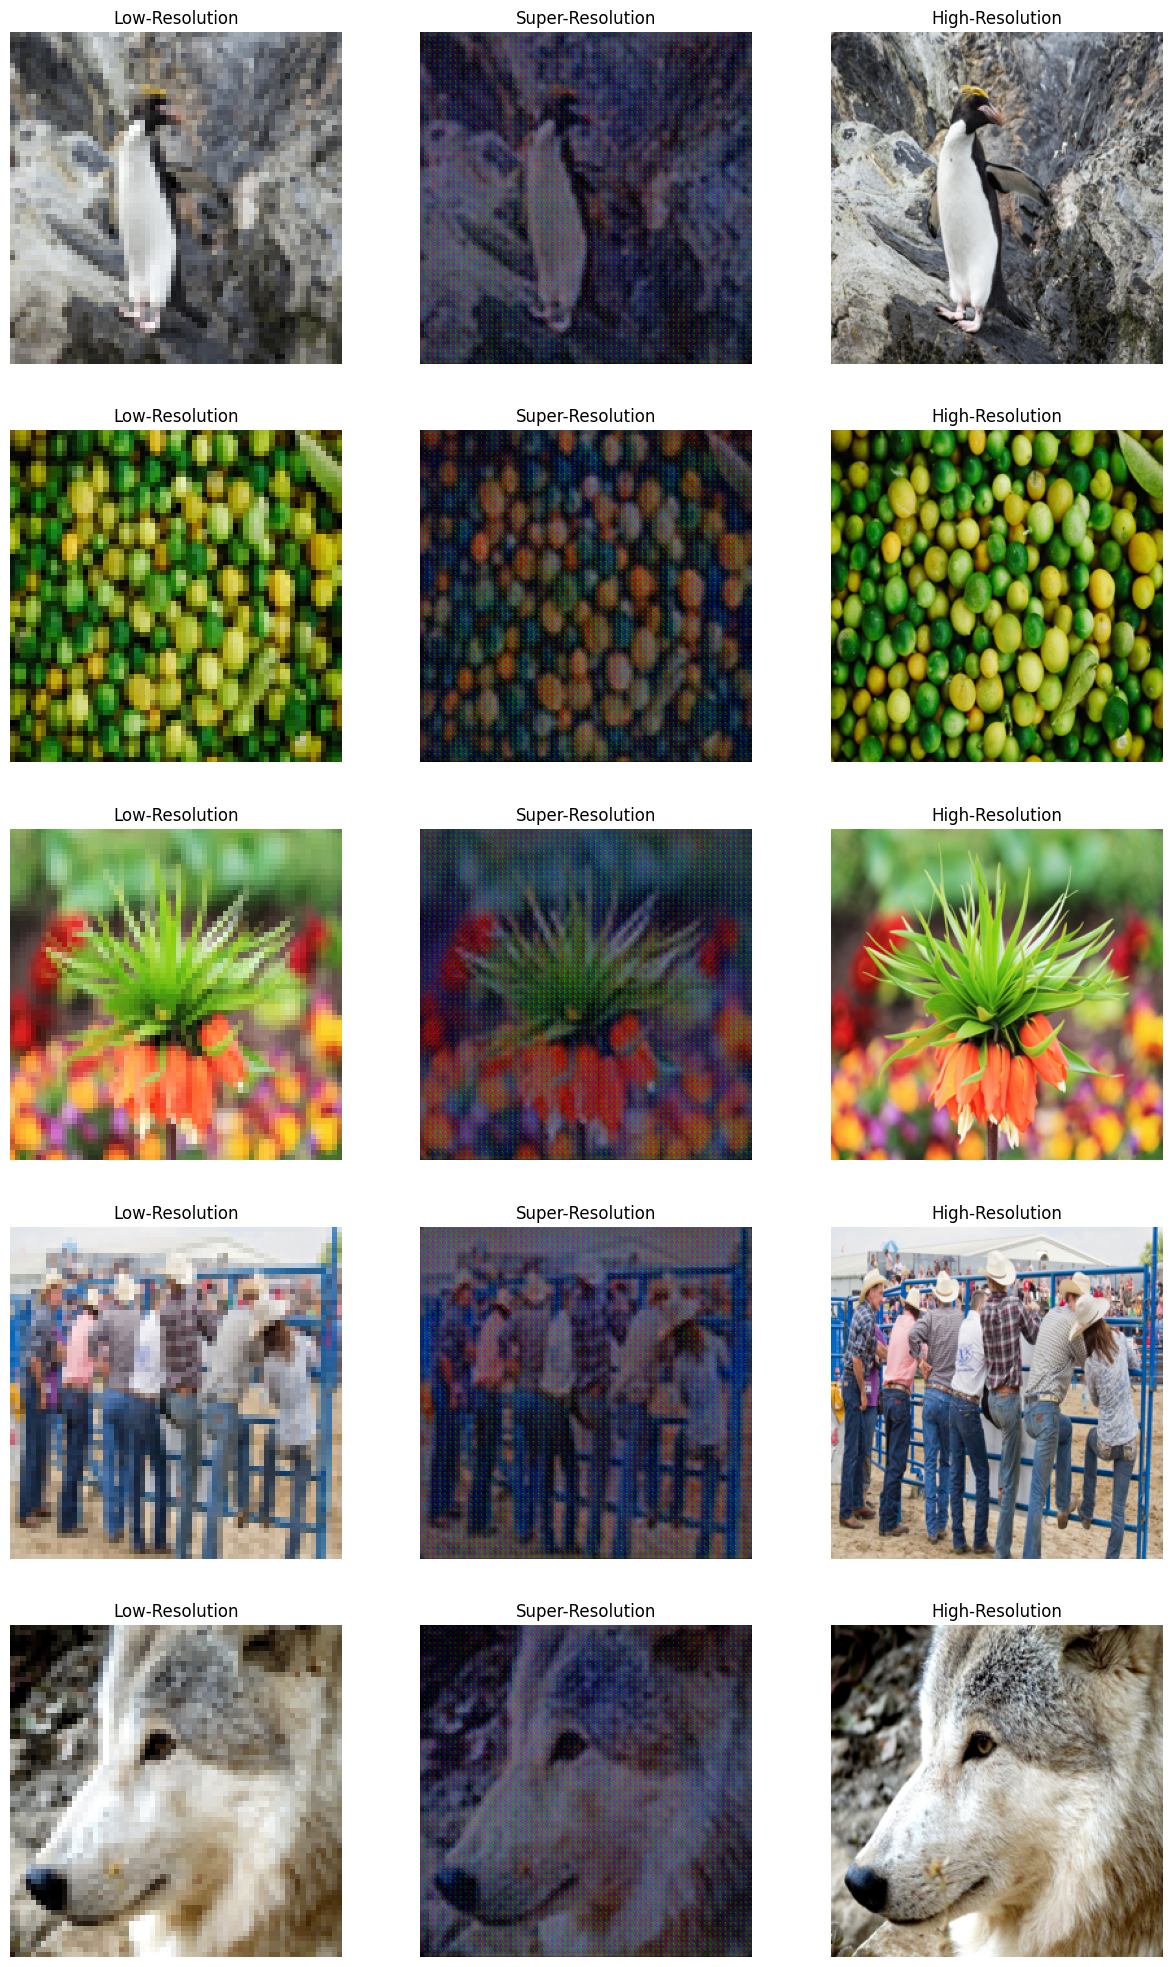

In [10]:
# Call this function after training to visualize results
visualize_results(generator, valid_dataset, device)

In [11]:
!pip install pytorch_ssim

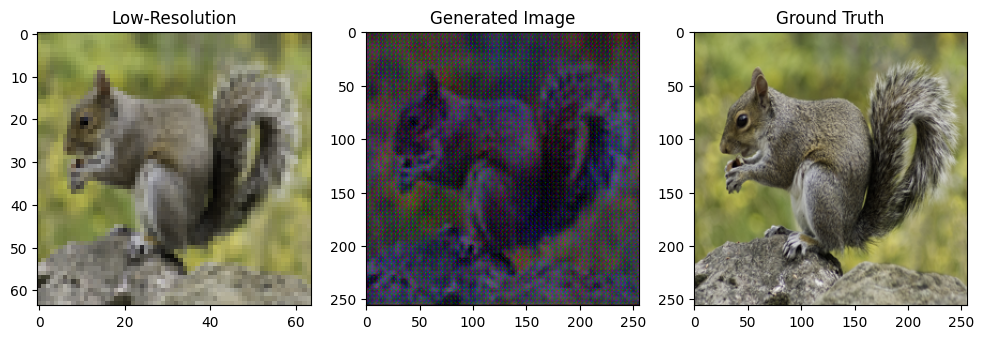

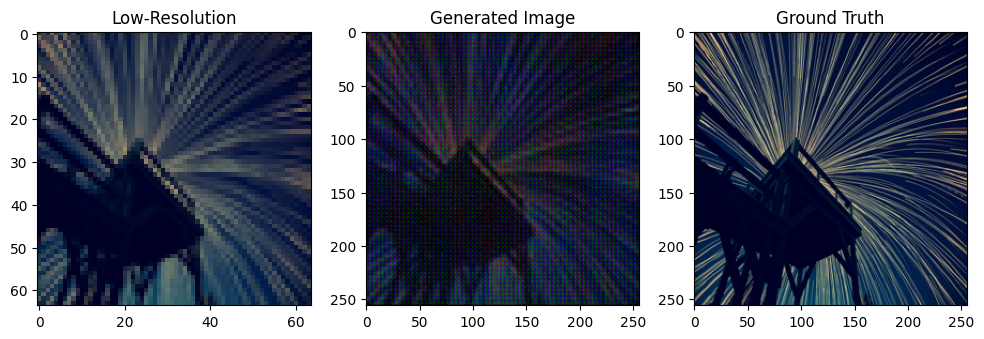

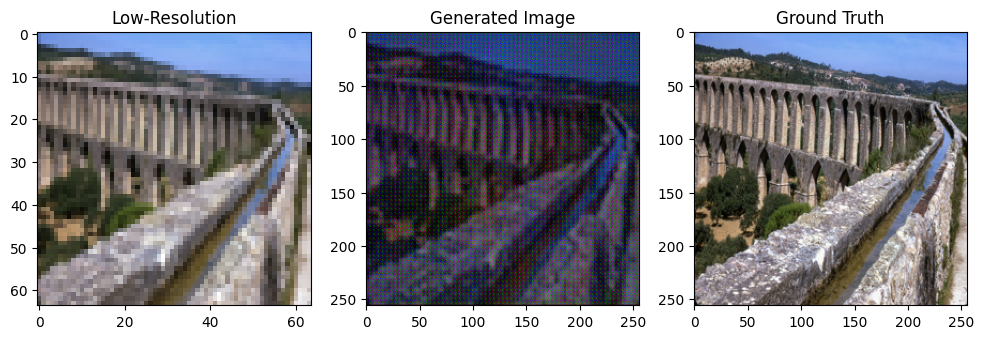

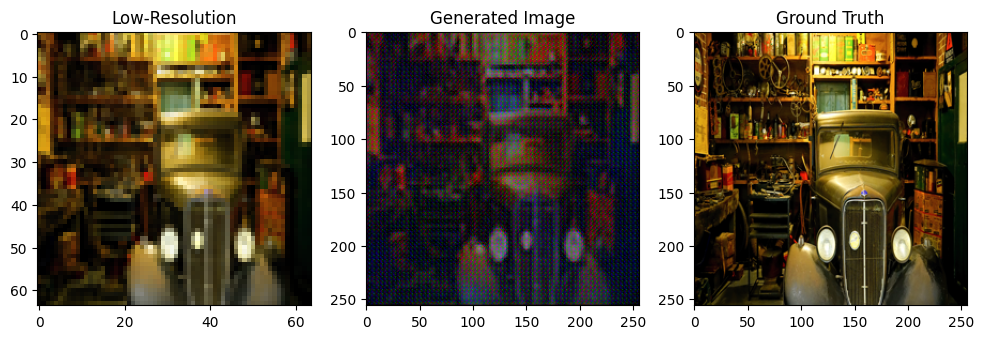

Average PSNR: 9.4137, Average SSIM: 0.1004


In [12]:
import torch
import pytorch_ssim
import matplotlib.pyplot as plt
# Example validation data loader (adjust as needed)
valid_dataset = DIV2KDataset(valid_hr_dir, transform=T.ToTensor(), crop_size=256)
validation_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
import torch
import torchmetrics
import matplotlib.pyplot as plt

def evaluate(generator, discriminator, validation_loader, device):
    generator.eval()  # Set the model to evaluation mode
    discriminator.eval()
    
    psnr_values = []
    ssim_values = []

    ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():  # Disable gradient computation during evaluation
        for lr_images, hr_images in validation_loader:
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Generate images
            fake_images = generator(lr_images)

            # Calculate metrics
            psnr = calculate_psnr(fake_images, hr_images)
            ssim = ssim_metric(fake_images, hr_images)
            
            psnr_values.append(psnr)
            ssim_values.append(ssim)

            # Optionally visualize a few sample results
            if len(psnr_values) < 5:  # Limit to 5 examples
                visualize_images(lr_images, fake_images, hr_images)

    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_ssim = sum(ssim_values) / len(ssim_values)
    print(f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}")

def calculate_psnr(output, target):
    mse = torch.mean((output - target) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def visualize_images(lr_images, fake_images, hr_images):
    # Convert tensor to numpy for visualization
    lr_image = lr_images[0].cpu().numpy().transpose(1, 2, 0)
    fake_image = fake_images[0].cpu().numpy().transpose(1, 2, 0)
    hr_image = hr_images[0].cpu().numpy().transpose(1, 2, 0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title("Low-Resolution")
    plt.subplot(1, 3, 2)
    plt.imshow(fake_image)
    plt.title("Generated Image")
    plt.subplot(1, 3, 3)
    plt.imshow(hr_image)
    plt.title("Ground Truth")
    plt.show()

# Assuming validation_loader is already loaded and your model is ready
# You can evaluate it on the validation data
evaluate(generator, discriminator, validation_loader, device)


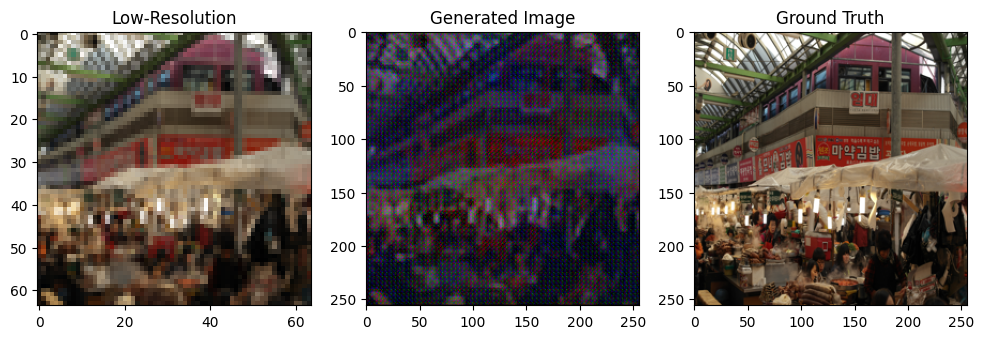

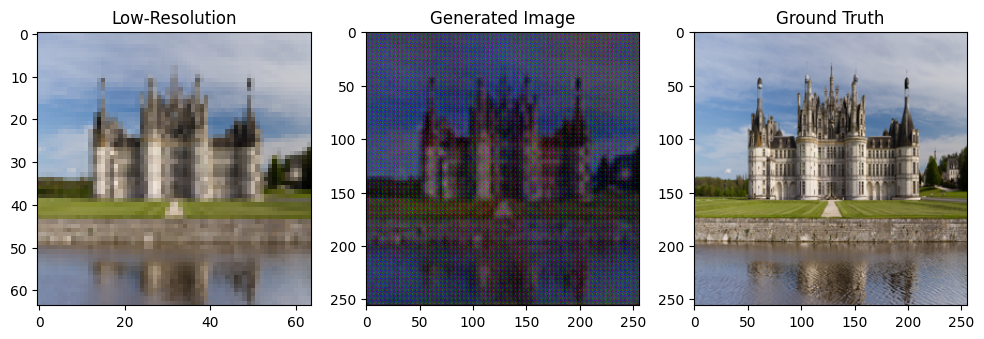

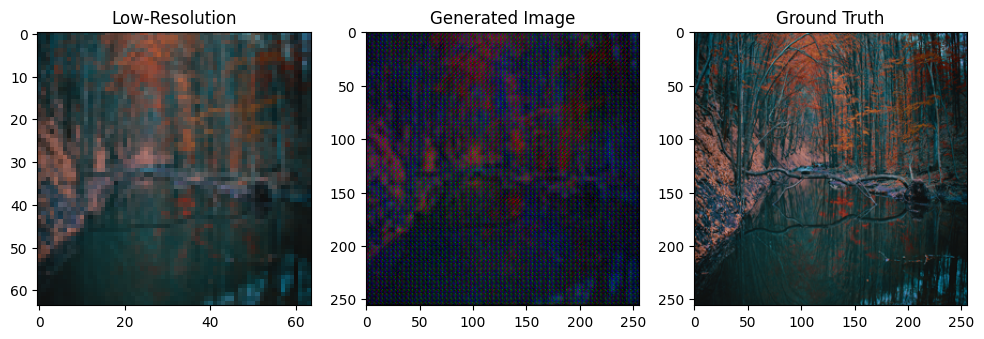

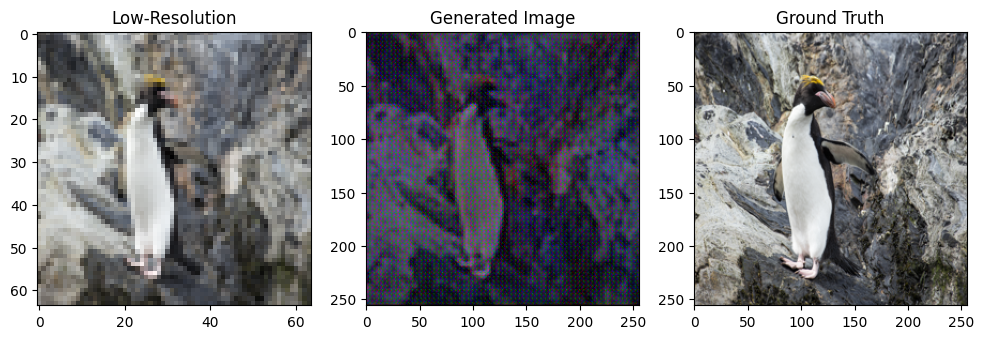

Average PSNR: 9.3666, Average SSIM: 0.1022


In [13]:
import torch
import pytorch_ssim
import matplotlib.pyplot as plt
# Example validation data loader (adjust as needed)
valid_dataset = DIV2KDataset(valid_hr_dir, transform=T.ToTensor(), crop_size=256)
validation_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
import torch
import torchmetrics
import matplotlib.pyplot as plt

def evaluate(generator, discriminator, validation_loader, device):
    generator.eval()  # Set the model to evaluation mode
    discriminator.eval()
    
    psnr_values = []
    ssim_values = []

    ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():  # Disable gradient computation during evaluation
        for lr_images, hr_images in validation_loader:
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Generate images
            fake_images = generator(lr_images)

            # Calculate metrics
            psnr = calculate_psnr(fake_images, hr_images)
            ssim = ssim_metric(fake_images, hr_images)
            
            psnr_values.append(psnr)
            ssim_values.append(ssim)

            # Optionally visualize a few sample results
            if len(psnr_values) < 5:  # Limit to 5 examples
                visualize_images(lr_images, fake_images, hr_images)

    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_ssim = sum(ssim_values) / len(ssim_values)
    print(f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}")

def calculate_psnr(output, target):
    mse = torch.mean((output - target) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def visualize_images(lr_images, fake_images, hr_images):
    # Convert tensor to numpy for visualization
    lr_image = lr_images[0].cpu().numpy().transpose(1, 2, 0)
    fake_image = fake_images[0].cpu().numpy().transpose(1, 2, 0)
    hr_image = hr_images[0].cpu().numpy().transpose(1, 2, 0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title("Low-Resolution")
    plt.subplot(1, 3, 2)
    plt.imshow(fake_image)
    plt.title("Generated Image")
    plt.subplot(1, 3, 3)
    plt.imshow(hr_image)
    plt.title("Ground Truth")
    plt.show()

# Assuming validation_loader is already loaded and your model is ready
# You can evaluate it on the validation data
evaluate(generator, discriminator, validation_loader, device)
